In [1]:
import torch
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
import os, sys
import copy
import pandas as pd

sys.path.append('../')

from models import (
    AE,
    IRAE,
    load_pretrained
)

from models.modules import (
    FC_vec,
)

from bezier import Bezier, demo2bezier, bezier2traj, bezier_Riemannian_metric

from utils.utils import label_to_color
from sklearn.mixture import GaussianMixture

from loader.Toy_dataset import Toy

device = f'cuda:0'

Toy split training | torch.Size([10, 20])
Toy split training | torch.Size([15, 20])
Toy split training | torch.Size([20, 20])


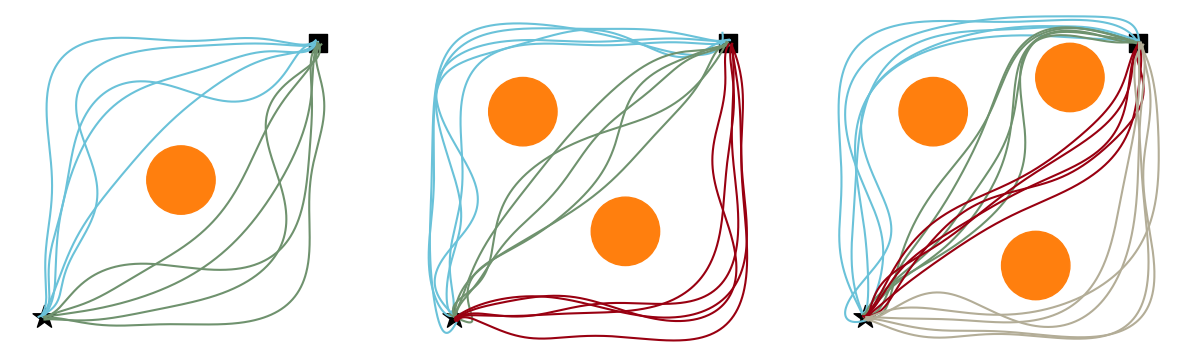

In [2]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ds = Toy(f'../datasets/EXP{i+1}/', num_control_points=10)

    ## ENV PARAMS
    env = ds.env
    bezier_params = ds.bezier_params
    dof = bezier_params['dof']
    T = bezier_params['T']
    xlim = env['xlim']
    ylim = env['ylim']
    init = env['start_point_pos']
    goal = env['final_point_pos']
    obstacles = env['obstacles']

    x = ds.data
    y = ds.targets.numpy()

    x_traj = bezier2traj(x, dof, T, traj_len=500)
    
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    
    for pos, rad in zip(obstacles['pos'], obstacles['rad']):
        theta = np.linspace(0, 2*np.pi, 100)
        Obs = Circle(xy=pos, radius=rad, color='tab:orange')
        axs[i].add_patch(Obs)

    for traj, label in zip(x_traj, y):
        color = label_to_color(np.array(label).reshape(1))
        axs[i].plot(traj[:, 0], traj[:, 1], c=color/255)

## RESULTS

In [3]:
num_exp = 3
num_calsses = 4
num_samples = 10 * num_calsses
root = f'../results/Toy/Exp{num_exp}/'

In [4]:
ae, cfg = load_pretrained('ae_zdim5_nc10_regnone_seed1', 'ae.yml', 'model_best.pkl', root=root)
irae, cfg = load_pretrained('irae_zdim5_nc10_reg0.01_seed1', 'irae.yml', 'model_best.pkl', root=root)
irae_bezier, cfg = load_pretrained('irae-bezier_zdim5_nc10_reg1_seed1', 'irae-bezier.yml', 'model_best.pkl', root=root)

## ENV PARAMS
ds = Toy(f'../datasets/EXP{num_exp}/')
env = ds.env
bezier_params = ds.bezier_params
dof = bezier_params['dof']
T = bezier_params['T']
xlim = env['xlim']
ylim = env['ylim']
init = env['start_point_pos']
goal = env['final_point_pos']
obstacles = env['obstacles']

Toy split training | torch.Size([20, 20])


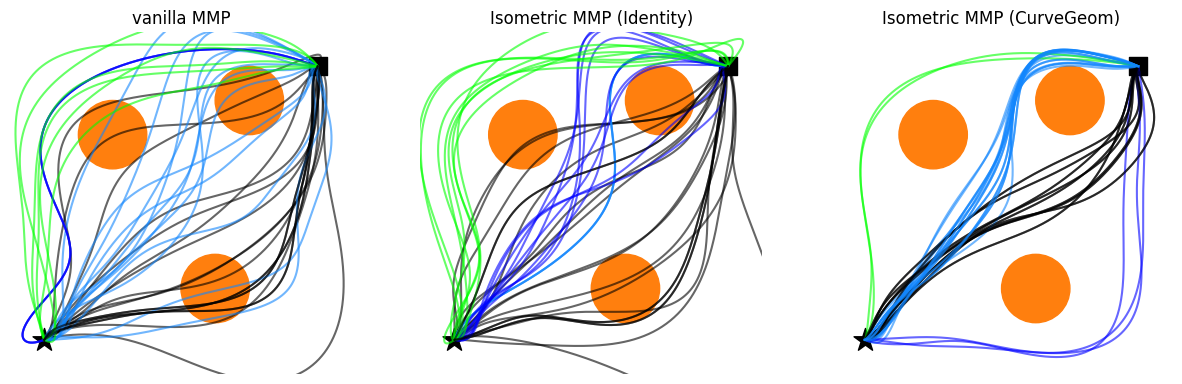

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

x = ds.data
y = ds.targets.numpy()

x_traj = bezier2traj(x, dof, T, traj_len=500)

for i in range(3):
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')

    for pos, rad in zip(obstacles['pos'], obstacles['rad']):
        theta = np.linspace(0, 2*np.pi, 100)
        Obs = Circle(xy=pos, radius=rad, color='tab:orange')
        axs[i].add_patch(Obs)
    
    if i == 0:
        model = ae
    elif i == 1:
        model = irae
    elif i == 2: 
        model = irae_bezier
    model.to(device);
    z = model.encode(x.to(device)).detach().cpu().numpy()
    
    ## SAMPLING
    gm = GaussianMixture(n_components=num_calsses, random_state=0).fit(z)

    thr = gm.score_samples(z).min()
    
    sample_z = []
    sample_y = []
    num_samples_ = 0
    while num_samples_ < num_samples:
        temp_z, temp_y = gm.sample(num_samples)
        temp_y = temp_y[gm.score_samples(temp_z) > thr]
        temp_z = temp_z[gm.score_samples(temp_z) > thr]
        num_samples_+=len(temp_z)
        sample_z.append(temp_z)
        sample_y.append(temp_y)
    sample_z = np.concatenate(sample_z, axis=0)[:num_samples]
    sample_y = np.concatenate(sample_y, axis=0)[:num_samples]
    
    c = sample_y.reshape(-1, 1)
    
    sample_x = model.decode(torch.tensor(sample_z, dtype=torch.float32).to(device))
    sampled_trajs = bezier2traj(
        sample_x, 2, 5, traj_len=500).detach().cpu()
    for traj, label in zip(sampled_trajs, sample_y):
        color = label_to_color((10-np.array(label)).reshape(1))
        axs[i].plot(traj[:, 0], traj[:, 1], c=color/255, alpha=0.6)
        
    mu = gm.means_
    cov = gm.covariances_

    xmin, xmax = axs[i].get_xbound()
    ymin, ymax = axs[i].get_ybound()
    
axs[0].set_title('vanilla MMP')
axs[1].set_title('Isometric MMP (Identity)')
axs[2].set_title('Isometric MMP (CurveGeom)')

plt.show()